In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Mounted at /content/drive
/content/drive/My Drive/ann challenge


## Import Libraries


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print('TensorFlow version:', tf.__version__)
print('Detected GPUs:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
sns.set_theme()

## Auxiliary functions

In [ ]:
def plot_time_series(x: np.ndarray) -> None:
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

In [ ]:
def plot_data_and_target(data, target, original = None):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the new data and the new target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='data', linewidth=2)
  plt.plot(indexes[len(data)-1:], np.concatenate((data[-1:],target[:]), axis=0), label='prediction', linewidth=2)

  if original is not None:
    # Plot the original data
    plt.plot(indexes, original, label='original', linestyle='--')

  plt.title("Time series")
  plt.legend()
  plt.show()

In [ ]:
def plot_data_and_target_2_batches(data, target, original = None):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the new data and the new target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='original sequence', linewidth=2)
  plt.plot(indexes[len(data)-1:len(data)+telescope], np.concatenate((data[-1:],target[:telescope]), axis=0), label='prediction (0-9)', linewidth=2)
  plt.plot(indexes[len(data)+telescope-1:], target[-telescope-1:], label='prediction (10-18)', linewidth=2, color='olivedrab')

  if original is not None:
    # Plot the original data
    plt.plot(indexes, original, label='original', linestyle='--')

  plt.title("Time series")
  plt.legend()
  plt.show()

## Load data

In [ ]:
data = np.load('preprocessed_data_stride_50.npz', allow_pickle=True)
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val= np.expand_dims(y_val, axis=-1)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (154277, 200, 1)
Training Label Shape: (154277, 9, 1)
Validation Data Shape: (17142, 200, 1)
Validation Label Shape: (17142, 9, 1)


## Build model

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]    # Input shape for the model
output_shape = y_train.shape[1:]   # Output shape for the model

# Print the defined parameters
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (200, 1)
Output Shape: (9, 1)


In [ ]:
def build_ensemble(input_shape: tuple[int, int], models_list: list[tfk.Model, ...], weights: list[float, ...] = None) -> tfk.Model:
    # Define the input
    input_layer = tfkl.Input(shape=input_shape, name='input')

    # Pass the input to the models
    y = [m(input_layer) for m in models_list]

    # Weight the individual contributions of the models
    if weights is not None:
      y = [yi * wi for yi, wi in zip(y, weights)]
      output_layer = tfkl.Add()(y)
    else:
      output_layer = tfkl.Average()(y)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='ensemble')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3), metrics=['mae'])

    # Return the model
    return model

In [ ]:
models_path = ['ResNet2B_CONV1D_BiGRU_with_stride_model', 'we_dont_need_attention', 'GRU_Conv1D_00532']

In [ ]:
# Instantiate the models that will be used in the ensemble in a list
models = []
for path in models_path:
    m = tfk.models.load_model('models/' + path)
    m._name = path
    m.trainable = False
    models.append(m)
models

In [ ]:
# the weights are the scores of the models on the test set
mse = [0.0048736478, 0.0049154655, 0.0053229192]
weights = [1 / score for score in mse]
weights = [wi / sum(weights) for wi in weights]

In [ ]:
print(mse)
print(weights)

[0.0048736478, 0.0049154655, 0.0053229192]
[0.3439866658128018, 0.3410602428331349, 0.31495309135406313]


## Ensemble (no weights)

In [ ]:
model = build_ensemble(input_shape, models, weights=None)
model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 ResNet2B_CONV1D_BiGRU_with  (None, 9)                    29881     ['input[0][0]']               
 _stride_model (Functional)                                                                       
                                                                                                  
 we_dont_need_attention (Fu  (None, 9)                    1339891   ['input[0][0]']               
 nctional)                                                3                                       
                                                                                           

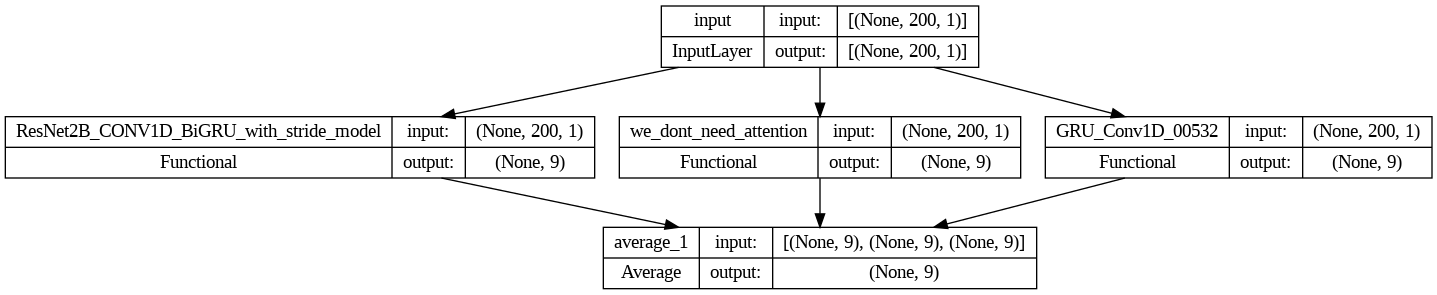

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

In [ ]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

536/536 [==============================] - 16s 22ms/step - loss: 0.0061 - mae: 0.0485
Mean Squared Error: 0.006075034849345684
Mean Absolute Error: 0.04851989075541496


In [ ]:
# Save the model
model_name = model.name
model.save('ensemble/combined/' + model.name + '-no-weights')
del model

### Autoregressive Model (no weights)

In [ ]:
# model_name is defined when we save the ensembles
model = tfk.models.load_model('ensemble/combined/' + model_name)

In [ ]:
# telescope is the number of timestamps that the model predicts
telescope = 9
# samples to predict is the total number of timestamps that we want to predict with the autoregressor model. This MUST be a factor of the telescope
samples_to_predict = telescope * 2
# test_sequences is the data we use to test the model. This will have to be changed with the Codalab data when submitting if we want to use this autoregressor model.
test_sequences = X_val[0:60]
sequences = np.copy(test_sequences)

i = 0
while i*telescope < samples_to_predict:
  pred = model.predict(sequences[:,:])
  for j in range(len(sequences)):
    for z in range(len(pred[j])):
      sequences[j] = np.delete(np.append(sequences[j], pred[j][z]), 0).reshape(-1, 1)
  i += 1

2/2 [==============================] - 0s 28ms/step


In [ ]:
# prediction inspection
index = np.random.randint(len(test_sequences))

In [ ]:
# plot_data_and_target(test_sequences[index], sequences[index,-samples_to_predict:])

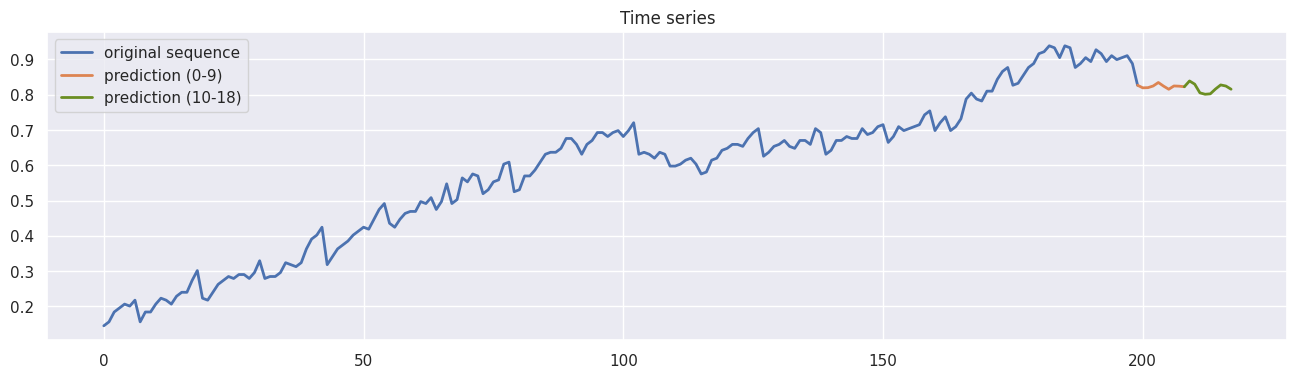

In [ ]:
# this plot function identifies only two prediction batches
# to plot different predictions amounts, uncomment the previous cell and modify the autoregressive code
plot_data_and_target_2_batches(test_sequences[index], sequences[index,-samples_to_predict:])

## Ensemble (with weights)

In [ ]:
model = build_ensemble(input_shape, models, weights=weights)
model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 ResNet2B_CONV1D_BiGRU_with  (None, 9)                    29881     ['input[0][0]']               
 _stride_model (Functional)                                                                       
                                                                                                  
 we_dont_need_attention (Fu  (None, 9)                    1339891   ['input[0][0]']               
 nctional)                                                3                                       
                                                                                           

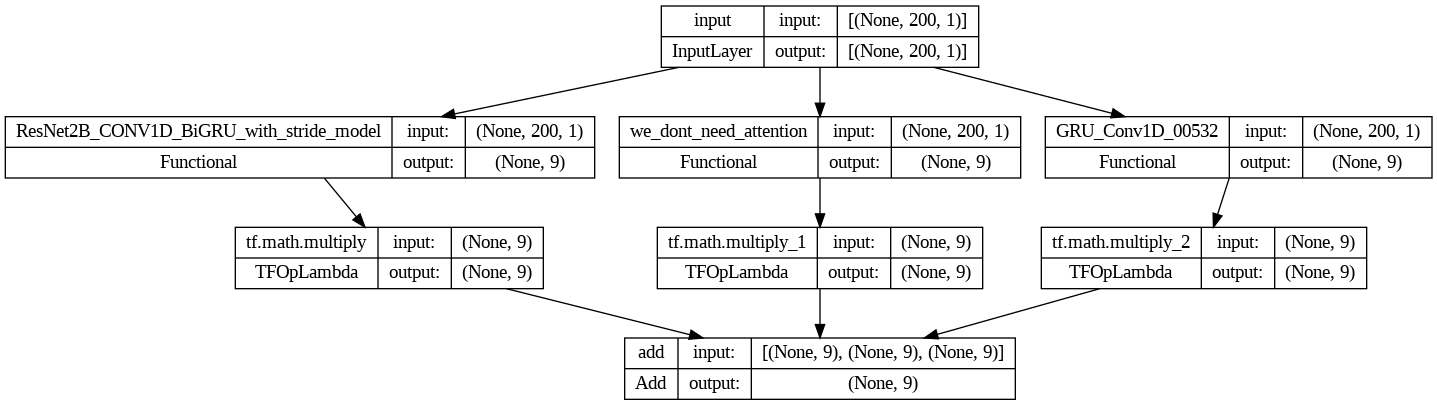

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

In [ ]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

536/536 [==============================] - 16s 25ms/step - loss: 0.0061 - mae: 0.0486
Mean Squared Error: 0.006095640826970339
Mean Absolute Error: 0.048618145287036896


In [ ]:
# Save the model
model_name = model.name
model.save('ensemble/combined/' + model.name)
del model

### Autoregressive Model (with weights)

In [ ]:
# model_name is defined when we save the ensembles
model = tfk.models.load_model('ensemble/combined/' + model_name)

In [ ]:
# telescope is the number of timestamps that the model predicts
telescope = 9
# samples to predict is the total number of timestamps that we want to predict with the autoregressor model. This MUST be a factor of the telescope
samples_to_predict = telescope * 2
# test_sequences is the data we use to test the model. This will have to be changed with the Codalab data when submitting if we want to use this autoregressor model.
test_sequences = X_val[0:60]
sequences = np.copy(test_sequences)

i = 0
while i*telescope < samples_to_predict:
  pred = model.predict(sequences[:,:])
  for j in range(len(sequences)):
    for z in range(len(pred[j])):
      sequences[j] = np.delete(np.append(sequences[j], pred[j][z]), 0).reshape(-1, 1)
  i += 1

2/2 [==============================] - 0s 29ms/step


In [ ]:
# prediction inspection
index = np.random.randint(len(test_sequences))

In [ ]:
# plot_data_and_target(test_sequences[index], sequences[index,-samples_to_predict:])

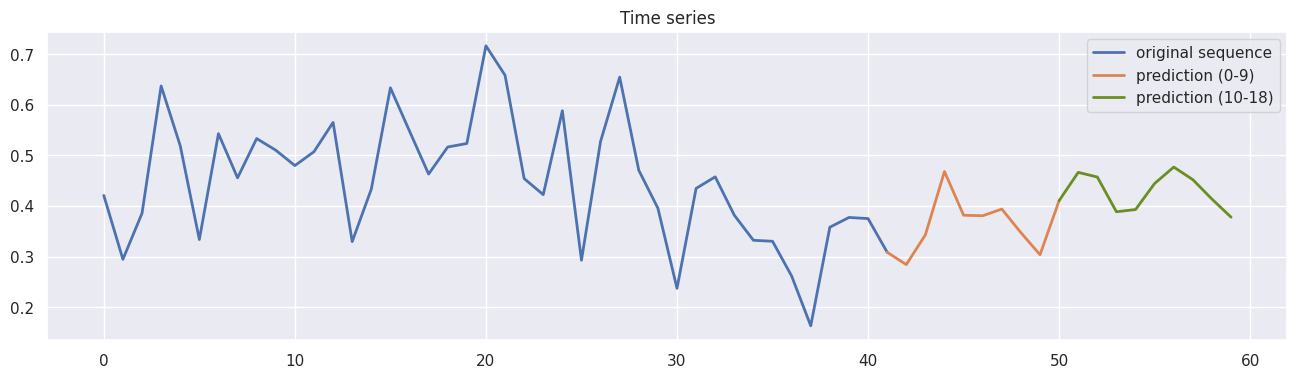

In [ ]:
# this function plots only two prediction batches,
# to plot different predictions amounts, uncomment the previous cell and modify the autoregressive code
plot_data_and_target_2_batches(test_sequences[index], sequences[index,-samples_to_predict:])